# EFAS - discharge
***

***Autor:** Jesús Casado Rodríguez*<br>
***Fecha:** 05-08-2023*<br>

**Introducción:**<br>


In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cf
from tqdm.notebook import tqdm

from funciones import *
from metricas_rendimiento import KGE, ECDF

## Configuración

In [2]:
# directorios con los datos de EFAS
path_EFAS = 'C:/Users/jcr693/Documents/EFASv5/'
path_discharge = f'{path_EFAS}iberia/discharge/'

# directorio con las capas GIS
path_GIS = '../data/GIS/'

# sistema de referencia de coordenadas de todos los datos
crs = 'epsg:4326'

# directorio donde guardar los resultados
path_out = '../data/EFASv5/discharge/'
if os.path.exists(path_out) is False:
    os.mkdir(path_out)

In [3]:
start = '1991-10-01'
end = '2020-09-30'

## Estaciones

In [4]:
# cargar estaciones
estaciones = gpd.read_file(f'{path_GIS}estaciones_seleccion_EFASv5.shp')
estaciones.set_index('indroea', drop=False, inplace=True)

# cargar subcuencas
subcuencas = gpd.read_file(f'{path_GIS}subcuencas_epsg4326.shp')
subcuencas.set_index('gauge_id', drop=False, inplace=True)

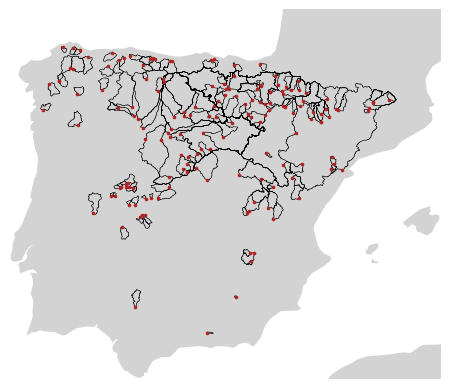

In [5]:
# plot subcuencas
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': proj})
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='lightgray'), zorder=0)
ax.set_extent([-9.5, 3.5, 36, 44.5], crs=proj)
subcuencas.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.35)
estaciones.plot(color='firebrick', marker='.', markersize=10, ax=ax)
ax.axis('off');

In [6]:
# x = xr.DataArray(stations.x, dims='id')
# y = xr.DataArray(stations.y, dims='id')

# discharge = discharge.sel(x=x, y=y, method='nearest')

## Caudal histórico EFASv5 

In [7]:
# cargar datos de los NetCDF
Qsim = xr.open_mfdataset(f'{path_discharge}EFASv5*.nc')['discharge'].compute().to_pandas()

# recortar al periodo de estudio
Qsim = Qsim.loc[start:end, :]

# exportar series de caudal observado
Qsim.to_parquet('../data/EFASv5/caudal/reanalisis_seleccion.parquet')

OSError: no files to open

Traer del PC del trabajo el código que extrae las series de caudal. Ver si es posible mover también los NetCDF originales de EFAS para la Península Ibérica.

Cargar las series del Anuario de Aforos y calcular el KGE de cada estación, y la CDF del conjunto.

## Caudal _Anuario de Aforos_

In [ ]:
path_AA = '../data/anuario_aforos/'

In [ ]:
cuencas = [dir for dir in os.listdir(path_AA) if os.path.isdir(os.path.join(path_AA, dir))]

Qobs = pd.DataFrame(index=pd.date_range(start, end, freq='1d'), dtype=float)
for cuenca in tqdm(cuencas):

    # cargar series temporales
    data = pd.read_csv(f'{path_AA}{cuenca}/afliq.csv', sep=';', index_col='indroea')
    data.index = data.index.astype(str)
    data.fecha = pd.to_datetime(data.fecha, dayfirst=True)

    # mantener sólo estaciones seleccionadas
    ids = list(set(data.index).intersection(estaciones.index))
    data = data.loc[ids, :]
    if data.shape[0] == 0:
        continue

    # recortar a la fecha de estudio
    data = data.loc[(data.fecha >= start) & (data.fecha <= end),:]

    # reformatear series de caudal y nivel
    Q = pd.DataFrame(index=pd.date_range(data.fecha.min(), data.fecha.max(), freq='1d'), columns=data.index.unique(), dtype=float) 
    for stn in Q.columns:
        data_stn = data.loc[stn].set_index('fecha', drop=True)
        Q[stn] = data_stn.caudal

    Qobs = pd.concat((Qobs, Q), axis=1)

In [ ]:
# exportar series de caudal observado
Qobs.to_parquet('../data/anuario_aforos/caudal_seleccion.parquet')

## Rendimiento EFASv5

In [ ]:
# calcular el coeficiente de eficiencia de Kling-Gupta de cada estación
estaciones['KGE_EFAS'] = pd.Series({id: KGE(Qobs[id], Qsim[id]) for id in estaciones.index}, name='KGE')

In [ ]:
# plot subcuencas
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': proj})
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='lightgray'), zorder=0)
ax.set_extent([-9.5, 3.5, 36, 44.5], crs=proj)
subcuencas.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.35)
estaciones.plot(c=estaciones.KGE_EFAS, cmap='coolwarm_r', markersize=10, ax=ax)
# ax.scatter(estaciones.geometry.x, estaciones.geometry.y, s=10, c=estaciones.KGE_EFAS, cmap='coolwarm')
ax.axis('off');

In [ ]:
ecdf_KGE = ECDF(estaciones.KGE_EFAS, plot=True, title='EFASv5', ylabel='KGE (-)')